# Introduction

The purpose of the project is to gain an introductory understanding of the relationship between Chloride concentrations of groundwater and rainfall as well as region location, population, density in New Zealand. Chloride can affect the taste of drinking water and affect corrosion at high concentrations (Ministry of Health, 2018).

The notebook includes three parts. The first one is to access the dataset by using Web API and Scraping as well as downloading from the website. The second part is data wrangling and integration including transforming, cleaning and merging dataset as well as some visualization. The last part is data analysis. Some grouped and pivot tables, graphs and an ANOVA test are created for purpose of finding deep insight from data. Finally, pooled regression and fixed effects regression are built to see the relationship between Chloride concentrations and rainfall

# Data Sources and Special Explanation

Four datasets have been used in the report. The first one is accessed from Web API, which describing 6 groundwater quality indicators datasets from 9 different sites in Auckland. The second one is download from the website https://www.lawa.org.nz/download-data/#groundwater-quality , which describes groundwater quality in different place of New Zealand from 2005 to 2019. The third dataset is from stats NZ  https://www.stats.govt.nz/indicators/rainfall, which describes daily rainfall in different place of New Zealand from 1965 to 2019. The last one is using web scraping to get a Wikipedia table from https://en.wikipedia.org/wiki/Regions_of_New_Zealand, which describes all regions' information in NZ.

Because the monitoring unit of the groundwater quality dataset(second dataset) is the site and the rainfall dataset is the station, two datasets have different geographical Monitoring unit. However, the groundwater quality dataset has variables 'region' and the rainfall dataset(third dataset) only has variable 'location_name' which is cities name, to join them together, the first dataset is used to make sure that there is no big difference of groundwater quality between different sites in the same region. Therefore, in the second and third dataset, Chloride concentrations of groundwater from different sites but the same region can be replaced by their mean. 

## Import modules

In [106]:
import requests                 
from bs4 import BeautifulSoup   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import seaborn as sns
# install linearmodes
!pip install linearmodels
from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [107]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 15
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

%matplotlib inline

# Data Acquistion

##  Web API for first dataset

 #### Using User-defined functions to get 6 indicators datasets from 9 different sites in Auckland 

In [108]:
def indicator(y):
    Site_ID = ['101674','101663','101664','101666','101665','101661','101648','101671','101675']  ### 9 sites represented by 9 string in API
    df_y = pd.DataFrame({'date':[],y:[],'site':[]})
    for a in Site_ID:
        response = requests.get("https://www.lawa.org.nz/umbraco/api/groundwaterqualityservice/GetTimeseriesGraphData?regionId=1066&siteId=LAWA-X&indicator=Q&standardUnitOfMeasure=mg/L&startYear=2003&endYear=2019".replace('X',a).replace('Q',y))
        res = json.loads(response.content)            ### loop for 9 sites
        def my_funtion_indicator(x):                  ### User-defined functions for converting json to pd.dataframe
            x_ = []
            x_date_jave = []
            x_date = []
            for i in range(len(res['IndicatorData']['Data'])):
                x_.append(res['IndicatorData']['Data'][i]['data'][0][1])
            for i in range(len(res['IndicatorData']['Data'])):
                x_date_jave.append(res['IndicatorData']['Data'][i]['data'][0][0])     ### it is a java timestamp 
            for time in x_date_jave:
                s = time / 1000.0
                x_date.append(datetime.datetime.fromtimestamp(s).strftime('%Y-%m-%d'))  ### converting java timestamp to datetime
            x_df = pd.DataFrame({'date':x_date, x:x_,'site':[a]*len(x_)})
            return x_df
        df_y  = df_y.append(my_funtion_indicator(x = y))         ### Concatenation for 9 dateframes into one dataframe
    return df_y

In [109]:
df_Chloride = indicator(y = 'CL')                         ### Chloride
df_Dissoled_reactive_phosphorus = indicator(y = 'DRP')    ### Dissoled reactive phosphorus
df_E_coll = indicator(y = 'ECOLI')                        ### E.coll
df_Electrical_conductivity = indicator(y = 'EC')          ###Electrical conductivity
df_Niitrate_nitrogen = indicator(y = 'NO3-N')             ### Niitrate nitrogen

#### Replacement sites' names
The site column has 9 different numbers representing 9 sites. To easy to understand, numbers are converted to meaningful names

In [110]:
Site = [df_Chloride,df_Dissoled_reactive_phosphorus,df_E_coll,df_Electrical_conductivity,df_Niitrate_nitrogen]
for a in Site:
    a['site'] = a['site'].replace('101674','BP Bombay').replace('101663','Fielding Rd Sand').replace('101664','Fielding Rd Volc').replace('101666','Hickey Springs').replace('101665','Hillview Springs').replace('101661','Ostrich Farm Obs No2').replace('101648','Patumahoe Springs').replace('101671','Watson Ave').replace('101675','Wilcox Gunclub Road')

In [111]:
###Combining 5 indicators dataframes into one dataframe
df_ground = pd.merge(pd.merge(pd.merge(pd.merge(df_Chloride, df_Dissoled_reactive_phosphorus, how='outer'),df_E_coll,how = 'outer'),df_Electrical_conductivity,how= 'outer'),df_Niitrate_nitrogen,how ='outer')
df_ground

,date,CL,site,DRP,ECOLI,EC,NO3-N
0,2003-01-29,19.7,BP Bombay,NaN,NaN,NaN,9.550
1,2003-01-30,19.5,BP Bombay,0.090,NaN,208.9,9.300
2,2003-05-27,19.4,BP Bombay,0.090,NaN,269.0,8.670
3,2003-09-10,24.1,BP Bombay,0.115,NaN,266.0,9.240
4,2003-10-22,14.8,BP Bombay,NaN,NaN,NaN,0.136
...,...,...,...,...,...,...,...
572,2010-10-15,NaN,Hickey Springs,NaN,NaN,NaN,24.100
573,2008-04-23,NaN,Patumahoe Springs,NaN,NaN,NaN,28.000
574,2008-10-22,NaN,Patumahoe Springs,NaN,NaN,NaN,27.000
575,2009-04-21,NaN,Patumahoe Springs,NaN,NaN,NaN,24.000


In [112]:
### Converting date column to timeseries 
df_ground['date'] = pd.to_datetime(df_ground['date'],format = '%Y-%m-%d')
### Setting date column as index 
df_ground = df_ground.set_index('date').sort_index()
df_ground           

,CL,site,DRP,ECOLI,EC,NO3-N
date,,,,,,
2003-01-24,15.6,Watson Ave,0.070,NaN,176.6,3.9000
2003-01-29,19.7,BP Bombay,NaN,NaN,NaN,9.5500
2003-01-29,NaN,Patumahoe Springs,NaN,NaN,277.4,26.8000
2003-01-30,19.5,BP Bombay,0.090,NaN,208.9,9.3000
2003-01-30,20.5,Fielding Rd Volc,0.040,NaN,268.6,0.0020
...,...,...,...,...,...,...
2019-10-11,18.4,Watson Ave,0.065,34.0,211.0,3.0000
2019-10-11,21.0,Fielding Rd Volc,0.036,1.0,327.0,0.0054
2019-10-12,18.5,Fielding Rd Sand,0.210,1.0,357.0,0.0010


## Visaulization

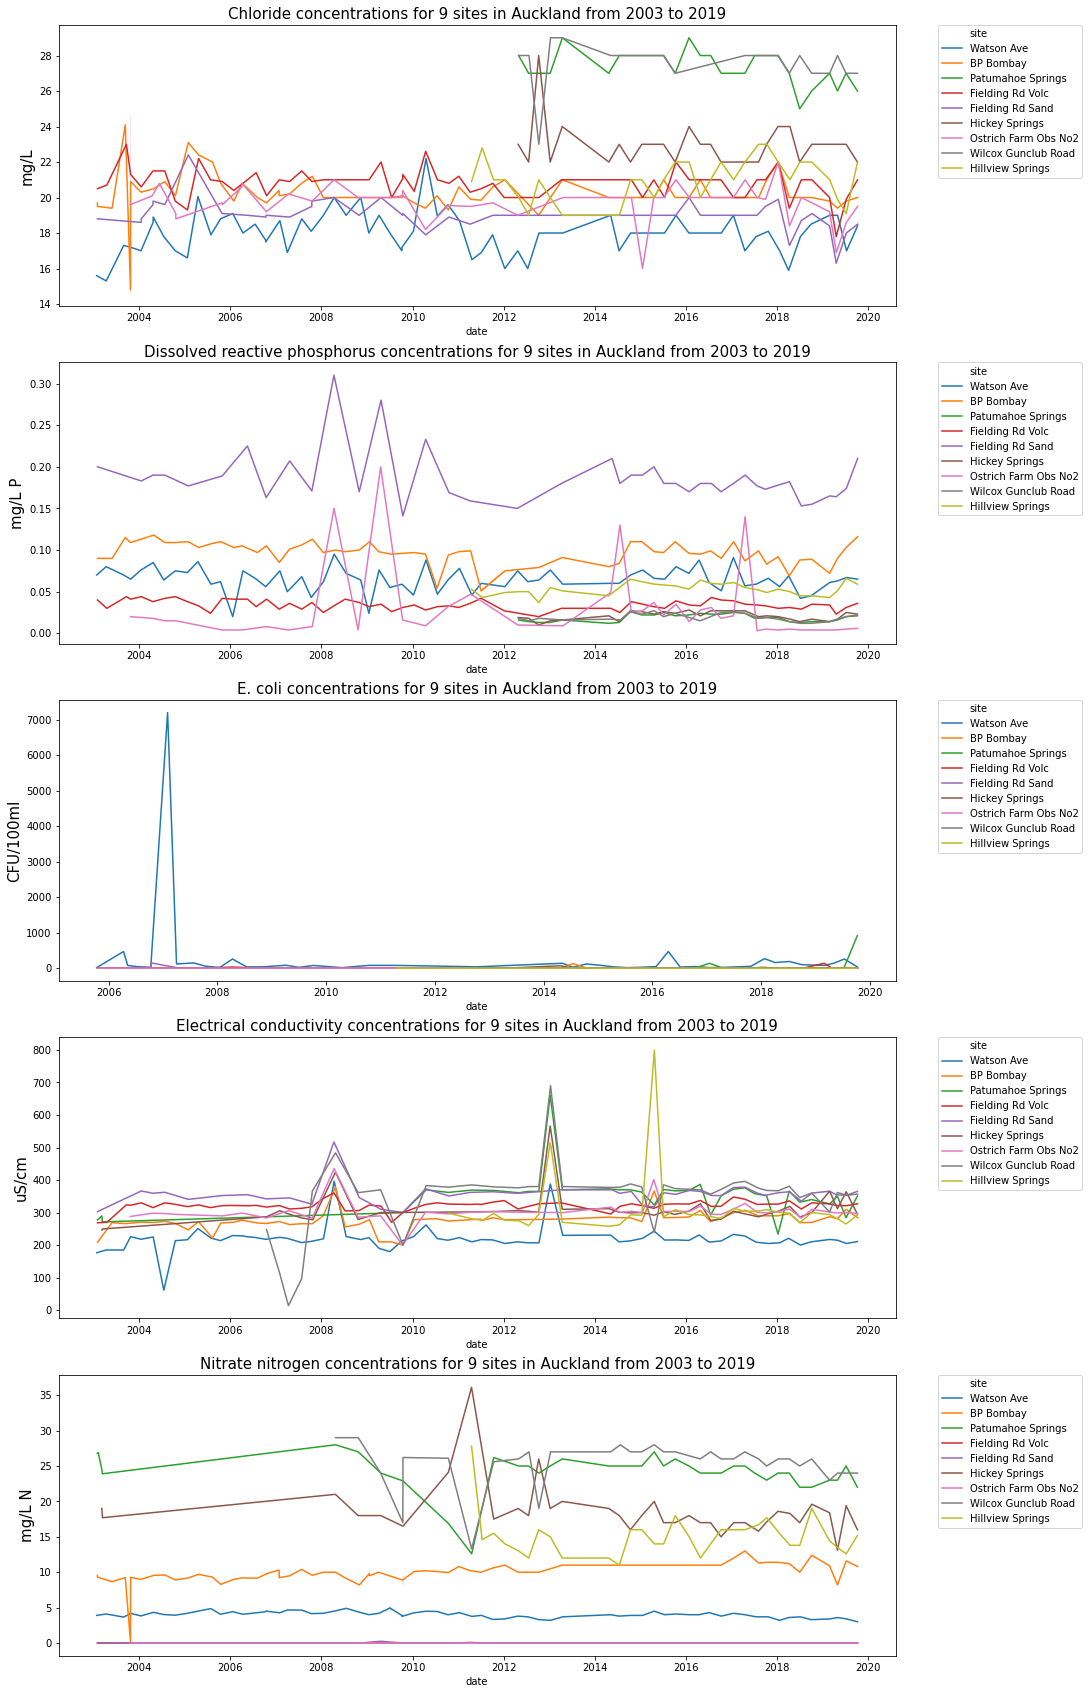

In [113]:
fig, axes = plt.subplots(5,1,figsize=(15,30))
## Chloride
## To making graph clearly to view, ylim is automatically setted as [14,30] instead of [0,30]
sns.lineplot(ax = axes[0],x= df_ground.index,y='CL', data=df_ground, hue='site')
axes[0].set_title('Chloride concentrations for 9 sites in Auckland from 2003 to 2019',size = 15)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_ylabel('mg/L',size = 15)

## Dissolved reactive phosphorus
sns.lineplot(ax = axes[1],x= df_ground.index,y = 'DRP',data = df_ground,hue ='site')
axes[1].set_title('Dissolved reactive phosphorus concentrations for 9 sites in Auckland from 2003 to 2019',size = 15)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylabel('mg/L P',size = 15)

## E. coli
sns.lineplot(ax = axes[2],x= df_ground.index,y = 'ECOLI',data = df_ground,hue ='site')
axes[2].set_title('E. coli concentrations for 9 sites in Auckland from 2003 to 2019',size = 15)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].set_ylabel('CFU/100ml',size = 15)

## Electrical conductivity
sns.lineplot(ax = axes[3],x= df_ground.index,y = 'EC',data = df_ground,hue ='site')
axes[3].set_title('Electrical conductivity concentrations for 9 sites in Auckland from 2003 to 2019',size = 15)
axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[3].set_ylabel('uS/cm',size = 15)

## Nitrate nitrogen
sns.lineplot(ax = axes[4],x= df_ground.index,y = 'NO3-N',data = df_ground,hue ='site')
axes[4].set_title('Nitrate nitrogen concentrations for 9 sites in Auckland from 2003 to 2019',size = 15)
axes[4].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[4].set_ylabel('mg/L N',size = 15)

plt.show()

As we can see from the above 6 graphs, Chloride concentrations from different sites in the Auckland region have the same trend over years. Others indicators concentrations are also the same situation except for E.coli because of the extreme value at 2007 in Watson Ave. Therefore, it is ok for using the mean value to replace indicators' concentrations from different sites but in the same region.

# Data Wrangling and Integration

## Groundwater quality dataset
The second dataset is downloaded from the website https://www.lawa.org.nz/download-data/#groundwater-quality , which describes groundwater quality in different place of New Zealand from 2005 to 2019

In [114]:
df_gwq = pd.read_excel('C:/Users/yy736/Assignment/datasets/Assignment 3 and 4/groundwater-quality-monitoring-data_statetrend-results_2005-2019.xlsx')
df_gwq

,Region Name,Agency,LAWA Site ID,LAWA Well Name,Latitude,Longitude,GWQ Zone,Indicator,Indicator Unit of Measure,Sample Date,Raw Value,Symbol,Censored Value
0,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-05-01 08:48:00,28,NaN,28.00
1,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-07-20 11:07:00,27,NaN,27.00
2,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-10-09 11:56:00,27,NaN,27.00
3,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-01-09 10:55:00,27,NaN,27.00
4,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-04-16 12:02:00,29,NaN,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127950,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2018-12-11 10:05:00,2.97,NaN,2.97
127951,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-03-22 13:20:00,2.55,NaN,2.55
127952,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-06-14 13:33:00,2.62,NaN,2.62
127953,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-09-13 13:45:00,2.53,NaN,2.53


In this report, only Chloride will be used as indicator in further analysis

In [115]:
#Selection of Chloride data
df_gwq_Chloride = df_gwq[df_gwq['Indicator'] =='Chloride']

# Converting Sample Date column as datetime64[D]
df_gwq_Chloride['Sample Date'] = pd.to_datetime(df_gwq_Chloride['Sample Date'],format = '%Y-%m-%d').astype('datetime64[D]')

# Renaming columns' name
df_gwq_Chloride = df_gwq_Chloride.rename(columns={'Sample Date':'date','Region Name':'Region','Censored Value':'Chloride'})

# Setting date as index
df_gwq_Chloride = df_gwq_Chloride.set_index('date').sort_index()

# Drop unneccessnary columns
df_gwq_Chloride = df_gwq_Chloride[['Region','Chloride','LAWA Site ID']]
df_gwq_Chloride

<ipython-input-115-eda94ae195d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gwq_Chloride['Sample Date'] = pd.to_datetime(df_gwq_Chloride['Sample Date'],format = '%Y-%m-%d').astype('datetime64[D]')


,Region,Chloride,LAWA Site ID
date,,,
2005-01-07,Gisborne,220.0,LAWA-101172
2005-01-07,Gisborne,50.0,LAWA-101183
2005-01-07,Gisborne,62.0,LAWA-101242
2005-01-07,Gisborne,43.0,LAWA-101232
2005-01-07,Gisborne,56.0,LAWA-101207
...,...,...,...
2019-12-20,Northland,154.0,LAWA-101886
2019-12-20,Northland,31.3,LAWA-101885
2019-12-23,Waikato,129.0,LAWA-101717


To merge with the rainfall dataset, different sites have been grouped by region

In [116]:
# Grouped reasult is a mutilindex dataframe
df_gwq_Chloride = df_gwq_Chloride[['Region','Chloride']].groupby(['date','Region']).mean() 

# Converting mutilindex to single index dataframe
df_gwq_Chloride.reset_index(level = [1],inplace=True) 

# Filling the missing value
df_gwq_Chloride['Chloride'].fillna(method = 'ffill')

df_gwq_Chloride

,Region,Chloride
date,,
2005-01-07,Gisborne,86.200000
2005-01-11,Canterbury,12.680000
2005-01-11,Marlborough,9.720000
2005-01-12,Canterbury,16.400000
2005-01-13,Marlborough,2.100000
...,...,...
2019-12-19,Southland,26.090000
2019-12-19,Taranaki,50.828571
2019-12-19,Waikato,9.920000


## Rainfall dataset
The rainfall dataset is downloaded from stats NZ https://www.stats.govt.nz/indicators/rainfall, which describes rainfall in different place of New Zealand from 1965 to 2019. (Downloaded file is a zip file, dataset used here is a csv file named daily_data)

The original rainfall dataset does not have the region column, to connect with groundwater quality and region dataset, a new column named region has been created according to relationship between location_name(city) and region.

In [117]:
# Reading datset from local disk
df_rainfall = pd.read_csv('C:/Users/yy736/Assignment/datasets/Assignment 3 and 4/daily_data.csv') 
df_rainfall

,location_name,date,rainfall,station_name_niwa,agent_number
0,Auckland,1960-01-01,0.0,Auckland Aero,1962
1,Auckland,1960-01-02,0.0,Auckland Aero,1962
2,Auckland,1960-01-03,9.2,Auckland Aero,1962
3,Auckland,1960-01-04,0.0,Auckland Aero,1962
4,Auckland,1960-01-05,0.0,Auckland Aero,1962
...,...,...,...,...,...
657445,Whangarei,2019-12-27,0.0,Whangarei Aero Aws,1287
657446,Whangarei,2019-12-28,0.0,Whangarei Aero Aws,1287
657447,Whangarei,2019-12-29,0.0,Whangarei Aero Aws,1287
657448,Whangarei,2019-12-30,0.0,Whangarei Aero Aws,1287


In [118]:
df_rainfall['date'] = pd.to_datetime(df_rainfall['date'],format = '%Y-%m-%d') # coverting to datetime
df_rainfall = df_rainfall.set_index('date')   # Setting timeseries index
df_rainfall = df_rainfall['2005':]   # Only use data after 2005
df_rainfall = df_rainfall.drop(columns = ['agent_number'])  # Drop unneccessnary columns
df_rainfall

,location_name,rainfall,station_name_niwa
date,,,
2005-01-01,Auckland,0.4,Auckland Aero
2005-01-02,Auckland,0.0,Auckland Aero
2005-01-03,Auckland,0.0,Auckland Aero
2005-01-04,Auckland,0.0,Auckland Aero
2005-01-05,Auckland,0.8,Auckland Aero
...,...,...,...
2019-12-27,Whangarei,0.0,Whangarei Aero Aws
2019-12-28,Whangarei,0.0,Whangarei Aero Aws
2019-12-29,Whangarei,0.0,Whangarei Aero Aws


In [119]:
# relationship between location_name and Region
Region_dict = {'location_name':
 ['Auckland', 'Blenheim','Christchurch', 'Dannevirke', 'Dunedin','Gisborne','Gore', 'Hamilton', 'Hokitika', 'Invercargill','Kerikeri', 'Lake Tekapo', 'Masterton', 'Milford Sound','Napier', 'Nelson', 'New Plymouth','Queenstown', 'Reefton', 'Rotorua','Tara Hills', 'Taumarunui', 'Taupo', 'Tauranga', 'Timaru','Waiouru', 'Wellington','Whanganui','Whangaparaoa', 'Whangarei'],
 'Region':
['Auckland','Marlborough','Canterbury','Manawatū-Whanganui','Otago','Gisborne','Southland','Waikato','West Coast','Southland','Northland','Canterbury','Wellington','Southland',"Hawke's Bay",'Marlborough','Taranaki','Otago','West Coast','Bay of Plenty','Otago','Manawatū-Whanganui','Waikato','Bay of Plenty','Canterbury','Manawatū-Whanganui','Wellington','Manawatū-Whanganui','Auckland','Northland']}
pd.DataFrame(Region_dict)

,location_name,Region
0,Auckland,Auckland
1,Blenheim,Marlborough
2,Christchurch,Canterbury
3,Dannevirke,Manawatū-Whanganui
4,Dunedin,Otago
5,Gisborne,Gisborne
6,Gore,Southland
7,Hamilton,Waikato
8,Hokitika,West Coast
9,Invercargill,Southland


In [120]:
# Creating Region by above relationship
d = {'Auckland':'Auckland','Blenheim':'Marlborough','Christchurch':'Canterbury','Dannevirke':'Manawatū-Whanganui','Dunedin':'Otago','Gisborne':'Gisborne','Gore':'Southland','Hamilton':'Waikato','Hokitika':'West Coast','Invercargill':'Southland','Kerikeri':'Northland','Lake Tekapo':'Canterbury','Masterton':'Wellington','Milford Sound':'Southland','Napier':"Hawke's Bay",'Nelson':'Tasman','New Plymouth':'Taranaki','Queenstown':'Otago','Reefton':'West Coast','Rotorua':'Bay of Plenty','Tara Hills':'Otago','Taumarunui':'Manawatū-Whanganui','Taupo':'Waikato','Tauranga':'Bay of Plenty','Timaru':'Canterbury','Waiouru':'Manawatū-Whanganui','Wellington':'Wellington','Whanganui':'Manawatū-Whanganui','Whangaparaoa':'Auckland','Whangarei':'Northland'}
df_rainfall['Region']= df_rainfall['location_name'].map(d)  
df_rainfall

,location_name,rainfall,station_name_niwa,Region
date,,,,
2005-01-01,Auckland,0.4,Auckland Aero,Auckland
2005-01-02,Auckland,0.0,Auckland Aero,Auckland
2005-01-03,Auckland,0.0,Auckland Aero,Auckland
2005-01-04,Auckland,0.0,Auckland Aero,Auckland
2005-01-05,Auckland,0.8,Auckland Aero,Auckland
...,...,...,...,...
2019-12-27,Whangarei,0.0,Whangarei Aero Aws,Northland
2019-12-28,Whangarei,0.0,Whangarei Aero Aws,Northland
2019-12-29,Whangarei,0.0,Whangarei Aero Aws,Northland


To merge with the groundwater quality dataset, different stations have been grouped by region

In [121]:
# Grouped reasult is a mutilindex dataframe
df_rainfall = df_rainfall.groupby(['date','Region']).mean()

# Converting mutilindex to single index dataframe
df_rainfall.reset_index(level = [1],inplace=True)
df_rainfall

,Region,rainfall
date,,
2005-01-01,Auckland,0.400000
2005-01-01,Bay of Plenty,1.200000
2005-01-01,Canterbury,2.766667
2005-01-01,Gisborne,0.000000
2005-01-01,Hawke's Bay,5.500000
...,...,...
2019-12-31,Taranaki,0.000000
2019-12-31,Tasman,0.000000
2019-12-31,Waikato,0.000000


### Data Integration

In [122]:
df = pd.merge(df_gwq_Chloride,df_rainfall,how = 'outer',on = ['date','Region'])
df

,Region,Chloride,rainfall
date,,,
2005-01-07,Gisborne,86.20,0.2
2005-01-11,Canterbury,12.68,0.0
2005-01-11,Marlborough,9.72,0.0
2005-01-12,Canterbury,16.40,0.0
2005-01-13,Marlborough,2.10,0.0
...,...,...,...
2019-12-31,Taranaki,NaN,0.0
2019-12-31,Tasman,NaN,0.0
2019-12-31,Waikato,NaN,0.0


### Data resampling

In [123]:
df['Chloride'].isnull().sum()

74769

Because the Chloride was recorded by quarter and rainfall are recorded monthly, there are 74769 missing values in the Chloride column while there are only 82170 rows. To get enough data for building regression models. The dataset is divided by region and resampled by quarter to fill the missing value.

The reason why the dataset is needed to be grouped by region is that if the dataset is resampled by a quarter without grouping by region, different regions will be resampled by quarter too which will lose the times of regions' number data.

In [124]:
# There are 15 Region in dataframe
list(df.groupby('Region').groups.keys())

['Auckland',
 'Bay of Plenty',
 'Canterbury',
 'Gisborne',
 "Hawke's Bay",
 'Manawatū-Whanganui',
 'Marlborough',
 'Northland',
 'Otago',
 'Southland',
 'Taranaki',
 'Tasman',
 'Waikato',
 'Wellington',
 'West Coast']

In [125]:
# Creating dictionary to save all dataframe because variable names can not be string
my_dict = {}                             
for a in list(df.groupby('Region').groups.keys()):
    my_dict[a] = df[df['Region'] == a].resample('Q').mean()

# Region column dissappeared because groupby only works for numeric columns
for i in list(df.groupby('Region').groups.keys()):
    my_dict[i]['Region'] = i

# Appending all region dataframe into a big dataframe
appended_data = []
for i in list(df.groupby('Region').groups.keys()):
    appended_data.append(my_dict[i])
df = pd.concat(appended_data)
df

,Chloride,rainfall,Region
date,,,
2005-03-31,19.550000,1.391111,Auckland
2005-06-30,21.175000,2.810440,Auckland
2005-09-30,20.300000,3.141304,Auckland
2005-12-31,19.743750,3.026087,Auckland
2006-03-31,19.600000,1.747778,Auckland
...,...,...,...
2018-12-31,6.144444,5.013587,West Coast
2019-03-31,8.575758,5.103333,West Coast
2019-06-30,6.525333,7.069780,West Coast


After grouping and resampling the data frame, the Chloride only has 84 missing values when there are 900 rows in the whole data frame.

In [126]:
df['Chloride'].isnull().sum()

84

## Region  dataset
For the last dataset, web scraping has been used to get a Wikipedia table from https://en.wikipedia.org/wiki/Regions_of_New_Zealand, which describes all regions' information in NZ.

In [127]:
# Making sure response is 200
url = "https://en.wikipedia.org/wiki/Regions_of_New_Zealand"
response = requests.get(url)
response

<Response [200]>

In [128]:
# Web scraping dataset
scraping_html_table = BeautifulSoup(response.content, "lxml") 
scraping_html_table = scraping_html_table.find_all("table", "wikitable")
scraping_html_table
df_region = pd.read_html(str(scraping_html_table))
df_region = df_region[0]
df_region

,Unnamed: 0,Region name(name in Māori if different),Regional council,Seats,Council seat,Island,Land area(km2)[21],Population[22],Density (pop./km2),ISO 3166-2 Code
0,1,NorthlandTe Tai Tokerau,Northland Regional Council,9,Whangārei,North,12504,194600,15.56,NZ-NTL
1,2,Auckland(1)Tāmaki-makau-rau,Auckland Council,21,Auckland,North,4941,1717500,347.60,NZ-AUK
2,3,Waikato,Waikato Regional Council,14,Hamilton,North,23900,496700,20.78,NZ-WKO
3,4,Bay of PlentyTe Moana-a-Toi,Bay of Plenty Regional Council,14,Whakatāne,North,12072,337300,27.94,NZ-BOP
4,5,Gisborne(1)(2)Te Tai Rāwhiti,Gisborne District Council,14,Gisborne,North,8385,50700,6.05,NZ-GIS
5,6,Hawke's BayTe Matau-a-Māui,Hawke's Bay Regional Council,9,Napier,North,14138,178600,12.63,NZ-HKB
6,7,Taranaki,Taranaki Regional Council,11,Stratford,North,7254,124600,17.18,NZ-TKI
7,8,Manawatū-Whanganui,Horizons Regional Council,12,Palmerston North,North,22221,254300,11.44,NZ-MWT
8,9,WellingtonTe Whanga-nui-a-Tara,Greater Wellington Regional Council,13,Wellington,North,8049,542000,67.34,NZ-WGN
9,10,Tasman(1)Te Tai-o-Aorere,Tasman District Council,13,Richmond,South,9616,56400,5.87,NZ-TAS


Because there is no commom regulation to modify every row of the Region name column, the manual modification for the Region name column has been used.

In [129]:
# After convert to list, I only need to manually delete the Māori name
df_region['Region name(name in Māori if different)'].tolist()

['NorthlandTe Tai Tokerau',
 'Auckland(1)Tāmaki-makau-rau',
 'Waikato',
 'Bay of PlentyTe Moana-a-Toi',
 'Gisborne(1)(2)Te Tai Rāwhiti',
 "Hawke's BayTe Matau-a-Māui",
 'Taranaki',
 'Manawatū-Whanganui',
 'WellingtonTe Whanga-nui-a-Tara',
 'Tasman(1)Te Tai-o-Aorere',
 'Nelson(1)Whakatū',
 'Marlborough(1)Te Tauihu-o-te-waka',
 'West CoastTe Tai Poutini',
 'CanterburyWaitaha',
 'OtagoŌtākou',
 'SouthlandMurihiku']

In [130]:
# Adding new region column according to old one.
df_region['Region'] = ['Northland','Auckland','Waikato','Bay of Plenty','Gisborne',"Hawke's Bay",'Taranaki','Manawatū-Whanganui',
'Wellington','Tasman','Nelson','Marlborough','West Coast','Canterbury','Otago','Southland']
# Drop unnecessary columns.
df_region = df_region[['Region','Island','Population[22]','Density (pop./km2)','Land area(km2)[21]']]
# Change some columns' names.
df_region.rename(columns = {'Population[22]':'Population','Land area(km2)[21]':'Land area(km2)'},inplace = True)
df_region

C:\Users\yy736\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Region,Island,Population,Density (pop./km2),Land area(km2)
0,Northland,North,194600,15.56,12504
1,Auckland,North,1717500,347.60,4941
2,Waikato,North,496700,20.78,23900
3,Bay of Plenty,North,337300,27.94,12072
4,Gisborne,North,50700,6.05,8385
5,Hawke's Bay,North,178600,12.63,14138
6,Taranaki,North,124600,17.18,7254
7,Manawatū-Whanganui,North,254300,11.44,22221
8,Wellington,North,542000,67.34,8049
9,Tasman,South,56400,5.87,9616


After checking whether the two data frames have the same amount of regions, the result is no. As we can see, the data frame from the Wikipedia table considers Nelson as an independent region. According to the Chloride and rainfall data frame, Nelson will be considered as the Marlborough region.

In [131]:
print(set(list(df['Region'].unique())))         # it does not include Nelson
print(set(list(df_region['Region'].unique())))  # it does include Nelson
set(list(df['Region'].unique())) == set(list(df_region['Region'].unique()))

{'Northland', 'Marlborough', 'Canterbury', 'West Coast', 'Gisborne', 'Wellington', 'Manawatū-Whanganui', 'Taranaki', 'Waikato', "Hawke's Bay", 'Auckland', 'Otago', 'Tasman', 'Southland', 'Bay of Plenty'}
{'Northland', 'Marlborough', 'Canterbury', 'Nelson', 'West Coast', 'Gisborne', 'Wellington', 'Taranaki', 'Manawatū-Whanganui', 'Tasman', "Hawke's Bay", 'Auckland', 'Otago', 'Waikato', 'Southland', 'Bay of Plenty'}


False

In [132]:
# recalculation of Marlborough row
df_region.loc[11,['Population']] = df_region.loc[11,['Population']] + df_region.loc[10,['Population']]
df_region.loc[11,['Land area(km2)']] = df_region.loc[11,['Land area(km2)']] + df_region.loc[10,['Land area(km2)']]
print(df_region.loc[11,['Population']])
print(df_region.loc[11,['Land area(km2)']])
df_region.loc[11,['Density (pop./km2)']]= round(104800/ 10880,2)
# drop Nelson row
df_region = df_region.drop(10)
df_region

Population    104800
Name: 11, dtype: object
Land area(km2)    10880
Name: 11, dtype: object


C:\Users\yy736\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Region,Island,Population,Density (pop./km2),Land area(km2)
0,Northland,North,194600,15.56,12504
1,Auckland,North,1717500,347.60,4941
2,Waikato,North,496700,20.78,23900
3,Bay of Plenty,North,337300,27.94,12072
4,Gisborne,North,50700,6.05,8385
5,Hawke's Bay,North,178600,12.63,14138
6,Taranaki,North,124600,17.18,7254
7,Manawatū-Whanganui,North,254300,11.44,22221
8,Wellington,North,542000,67.34,8049
9,Tasman,South,56400,5.87,9616


In [133]:
# Checking again
print(set(list(df['Region'].unique())))
print(set(list(df_region['Region'].unique())))
set(list(df['Region'].unique())) == set(list(df_region['Region'].unique()))

{'Northland', 'Marlborough', 'Canterbury', 'West Coast', 'Gisborne', 'Wellington', 'Manawatū-Whanganui', 'Taranaki', 'Waikato', "Hawke's Bay", 'Auckland', 'Otago', 'Tasman', 'Southland', 'Bay of Plenty'}
{'Northland', 'Marlborough', 'Canterbury', 'West Coast', 'Gisborne', 'Wellington', 'Taranaki', 'Manawatū-Whanganui', 'Tasman', "Hawke's Bay", 'Auckland', 'Otago', 'Waikato', 'Southland', 'Bay of Plenty'}


True

In [134]:
# merge region dataframe with chloride and rainfall dataframe
df = pd.merge(df,df_region,how= 'outer').set_index(df.index)
df

,Chloride,rainfall,Region,Island,Population,Density (pop./km2),Land area(km2)
date,,,,,,,
2005-03-31,19.550000,1.391111,Auckland,North,1717500,347.60,4941
2005-06-30,21.175000,2.810440,Auckland,North,1717500,347.60,4941
2005-09-30,20.300000,3.141304,Auckland,North,1717500,347.60,4941
2005-12-31,19.743750,3.026087,Auckland,North,1717500,347.60,4941
2006-03-31,19.600000,1.747778,Auckland,North,1717500,347.60,4941
...,...,...,...,...,...,...,...
2018-12-31,6.144444,5.013587,West Coast,South,32400,1.39,23245
2019-03-31,8.575758,5.103333,West Coast,South,32400,1.39,23245
2019-06-30,6.525333,7.069780,West Coast,South,32400,1.39,23245


# Data Analysis

### Subsample analysis 
##### (Groupby function, Pivot tables, Visualisation and ANOVA test)

In [135]:
grouped = df.groupby('Region')
result = grouped.agg(['count','mean','median','min','max','std'])
result

Chloride                                                 \
                      count        mean      median        min         max   
Region                                                                       
Auckland                 57   20.346114   20.222222  19.000000   25.375000   
Bay of Plenty            35   76.854584   53.002628   8.337500  298.025000   
Canterbury               60   15.701322   15.183390  11.067056   22.513705   
Gisborne                 60  112.075668  107.402891  48.693750  185.512500   
Hawke's Bay              59   21.615030   21.410185   7.450000   48.987500   
Manawatū-Whanganui       38   43.600396   41.987897  15.702000   82.950000   
Marlborough              60   13.522043   12.834122   6.835714   27.825694   
Northland                60   87.798218   81.197500  57.727157  172.569872   
Otago                    57   20.473550   19.840694   2.256000   67.200000   
Southland                60   22.948253   21.133719  15.827961   49.656429   
Taranaki                 31   27.251339   27.521925  16.550000   44.442857   
Tasman                   60   16.906395   15.790778   6.283333   46.046825   
Waikato                  60   18.796725   18.352395  11.271667   30.208889   
Wellington               60   40.934615   40.902980  21.204630   55.502778   
West Coast               59    7.979480    7.308333   4.750000   15.664000   

                              rainfall                                ...  \
                          std    count      mean    median       min  ...   
Region                                                                ...   
Auckland             1.029668       60  2.909447  2.821703  0.613889  ...   
Bay of Plenty       67.731228       60  3.579478  3.293681  0.718333  ...   
Canterbury           2.886361       60  1.636145  1.469928  0.722222  ...   
Gisborne            29.631745       60  2.995126  2.921739  0.764444  ...   
Hawke's Bay          5.910497       60  2.154623  1.954444  0.514444  ...   
Manawatū-Whanganui  11.303060       60  2.962485  3.044022  1.083242  ...   
Marlborough          4.397085       60  1.968103  1.924903  0.445652  ...   
Northland           25.026250       60  3.943095  3.920763  0.822222  ...   
Otago               11.694761       60  1.747575  1.702645  0.965942  ...   
Southland            6.450391       60  7.938845  7.595048  4.634799  ...   
Taranaki             5.337720       60  3.709307  3.539560  1.304348  ...   
Tasman               6.297376       60  2.692815  2.308394  0.927174  ...   
Waikato              3.904486       60  2.935067  2.889402  0.643889  ...   
Wellington           5.550967       60  3.010760  2.998641  1.131111  ...   
West Coast           2.378746       60  6.395058  6.304626  3.480000  ...   

                   Density (pop./km2)                      Land area(km2)  \
                               median     min     max  std          count   
Region                                                                      
Auckland                       347.60  347.60  347.60  0.0             60   
Bay of Plenty                   27.94   27.94   27.94  0.0             60   
Canterbury                      14.51   14.51   14.51  0.0             60   
Gisborne                         6.05    6.05    6.05  0.0             60   
Hawke's Bay                     12.63   12.63   12.63  0.0             60   
Manawatū-Whanganui              11.44   11.44   11.44  0.0             60   
Marlborough                      9.63    9.63    9.63  0.0             60   
Northland                       15.56   15.56   15.56  0.0             60   
Otago                            7.87    7.87    7.87  0.0             60   
Southland                        3.29    3.29    3.29  0.0             60   
Taranaki                        17.18   17.18   17.18  0.0             60   
Tasman                           5.87    5.87    5.87  0.0             60   
Waikato                         20.78   20.78   20.78  0.0             6

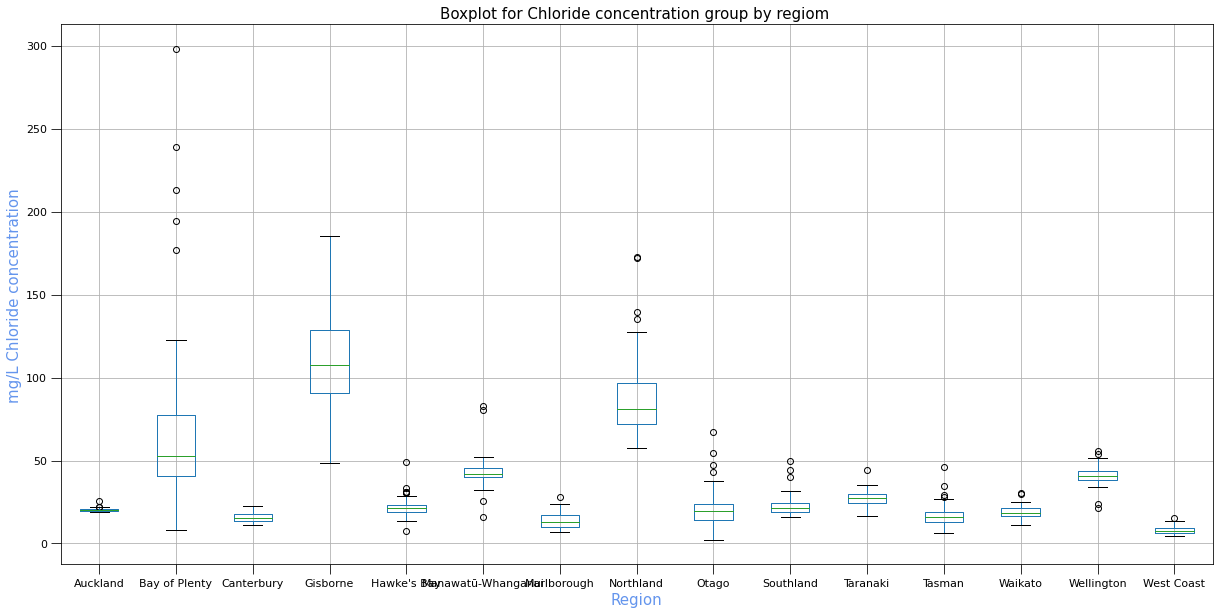

In [136]:
df.boxplot('Chloride',by = 'Region',figsize = (20,10))
plt.ylabel('mg/L Chloride concentration',color = 'cornflowerblue',size = 15 )
plt.xlabel('Region',color = 'cornflowerblue',size = 15 )
plt.suptitle('')
plt.title('Boxplot for Chloride concentration group by regiom ',size = 15)
plt.tick_params(colors = 'black',size =10,labelsize = 11)

According to Drinking-water Standards for New Zealand (DWSNZ) benchmark, The guideline value for chloride concentrations in drinking water is 250 mg/L. Concentrations above this may affect the taste of the water.

As we can see from the above boxplot, Bay of Plenty, Gisborne and Northland are outstanding groups with very high Chloride concentration. Especially Bay of Plenty, even its median is around 50mg/L but it has several extreme values. The medians of the rest of the regions all are below 50mg/L and their maximums are all below 100mg/L.

#### ANOVA Test for Chloride concentrations and regions.

In [137]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('Chloride ~ C(Region)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Region),763624.701110,14.0,162.097069,1.910199e-222
Residual,269531.350718,801.0,NaN,NaN


As we can see from the above table, the p-value obtained from ANOVA analysis is 1.910199e-222, and therefore, we conclude that there is a significant difference in Chloride concentrations among different regions.

In [138]:
pivot = df.pivot_table(index = ['date'],columns = 'Region')['Chloride']
pivot

Region,Auckland,Bay of Plenty,Canterbury,Gisborne,Hawke's Bay,Manawatū-Whanganui,Marlborough,Northland,Otago,Southland,Taranaki,Tasman,Waikato,Wellington,West Coast
date,,,,,,,,,,,,,,,
2005-03-31,19.550000,83.400000,21.781154,127.759077,15.213333,NaN,7.943929,81.364848,7.925833,18.503730,35.475000,13.877778,15.930882,43.925926,NaN
2005-06-30,21.175000,NaN,21.248570,141.250850,17.327500,51.291667,12.708125,82.010667,47.294000,18.311429,24.191667,16.612500,12.832121,43.560000,7.561111
2005-09-30,20.300000,NaN,14.413355,85.693452,13.825268,NaN,9.219167,75.791667,2.256000,17.906800,21.425000,16.010417,11.271667,36.339744,8.058333
2005-12-31,19.743750,NaN,11.120549,106.242063,18.898958,NaN,9.834286,71.390152,43.180000,16.823611,20.825000,12.370536,18.331647,47.792569,6.925000
2006-03-31,19.600000,71.211667,11.589981,114.466369,16.537963,82.950000,9.021429,78.599817,7.610000,19.310952,32.600000,12.796667,17.440000,21.204630,7.708333
2006-06-30,19.875000,NaN,15.443701,67.143878,18.471250,80.200000,6.835714,81.170758,67.200000,16.327778,20.887500,13.832593,16.938988,55.502778,8.266667
2006-09-30,19.966667,NaN,18.014613,93.133061,48.987500,NaN,11.065000,105.838462,3.000833,18.742024,21.400000,18.616667,19.864517,36.229872,6.800000
2006-12-31,19.012500,NaN,12.531422,151.307143,20.109722,NaN,9.431806,75.138194,37.466667,18.805026,26.800000,13.066667,20.347187,37.926389,8.250000
2007-03-31,19.600000,115.000000,22.513705,127.025640,33.250794,NaN,8.644048,94.042083,8.946190,19.789773,29.360000,15.912222,13.832500,46.228788,6.350000


(0.0, 200.0)

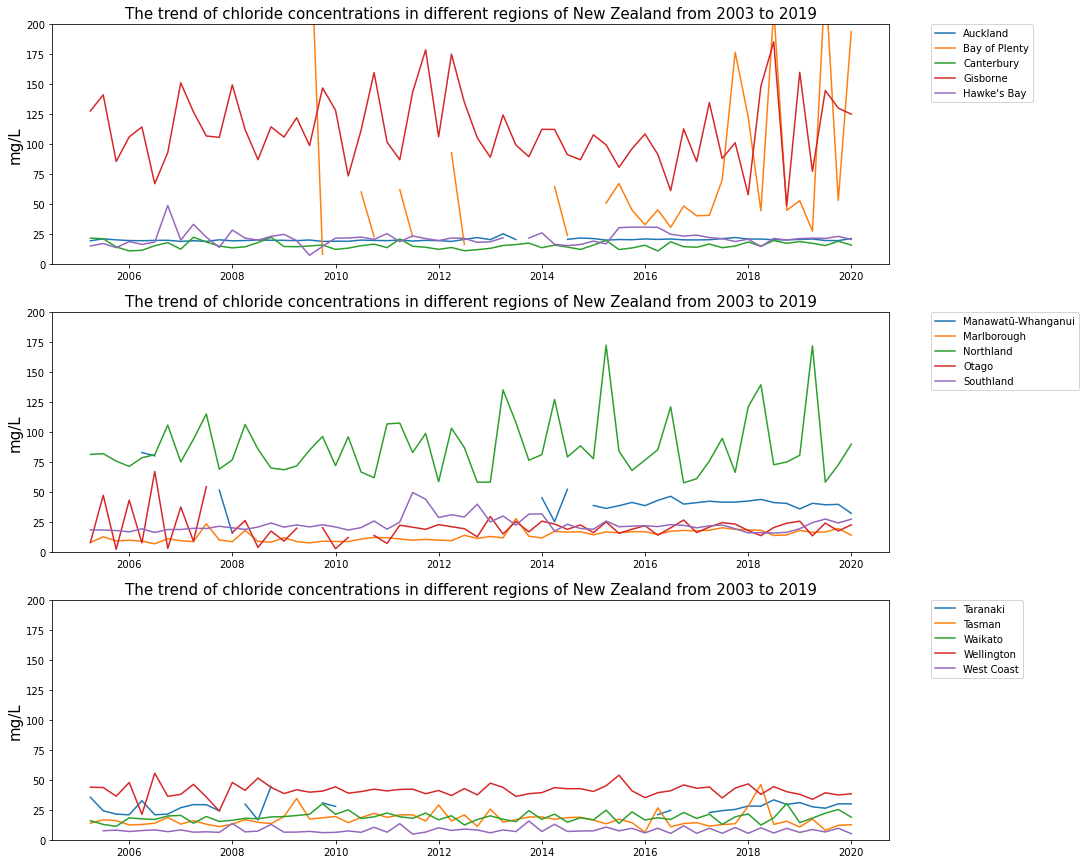

In [139]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
## Auckland Bay of Plenty Canterbury Gisbone Hawke's  Bay 
axes[0].plot(pivot.index,pivot.loc[:,'Auckland':"Hawke's Bay"])
axes[0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[0].set_ylabel('mg/L',size = 15)
axes[0].legend(pivot.loc[:,'Auckland':"Hawke's Bay"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_ylim(0,200)

## Manawatū-Whanganui Marlborough Northland Otago Southland
axes[1].plot(pivot.index,pivot.loc[:,'Manawatū-Whanganu':"Southland"])
axes[1].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[1].set_ylabel('mg/L',size = 15)
axes[1].legend(pivot.loc[:,'Manawatū-Whanganu':"Southland"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(0,200)

## Taranaki Tasman Waikato Wellington West Coast
axes[2].plot(pivot.index,pivot.loc[:,'Taranaki':"West Coast"])
axes[2].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[2].set_ylabel('mg/L',size = 15)
axes[2].legend(pivot.loc[:,'Taranaki':"West Coast"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].set_ylim(0,200)


From the above graphs, we can see more detail about the trend of chloride concentrations in different regions. 

For Bay of Plenty, it had extreme high chloride concentrations between 2009 and 2010 and after 2017 it got unusually high value again. 
For Gisborne, it had a lot of change in most of the years except for years between 2013 and 2016. For Northland, before 2012 it did have very strong fluctuation but it had a quite strong fluctuation. 

Auckland, the most densely populated region in New Zealand, has been very stable chloride since 2005.

For some regions like Manawatū-Whanganui and Taranaki, there was no data has been recorded for many years.

### North Island VS South Island  

In [140]:
grouped = df.groupby('Island')
result = grouped.agg(['count','mean','median','min','max','std'])
result[['Chloride','Density (pop./km2)']]

Chloride                                                   \
          count       mean     median    min      max        std   
Island                                                             
North       460  50.440969  37.662214  7.450  298.025  41.112063   
South       356  16.242872  15.666667  2.256   67.200   7.987473   

       Density (pop./km2)                                              
                    count       mean median   min     max         std  
Island                                                                 
North                 540  58.502222  17.18  6.05  347.60  103.716409  
South                 360   7.093333   6.87  1.39   14.51    4.298113

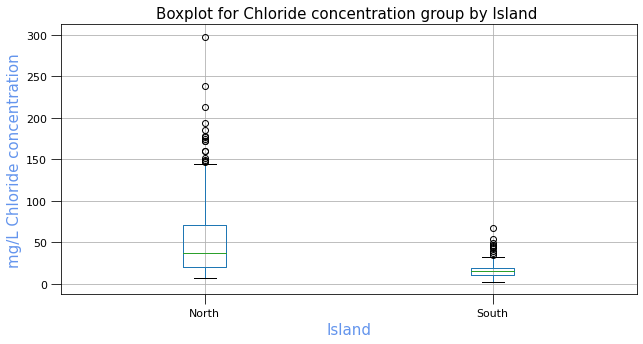

In [141]:
df.boxplot('Chloride',by = 'Island',figsize = (10,5))
plt.ylabel('mg/L Chloride concentration',color = 'cornflowerblue',size = 15 )
plt.xlabel('Island',color = 'cornflowerblue',size = 15 )
plt.suptitle('')
plt.title('Boxplot for Chloride concentration group by Island ',size = 15)
plt.tick_params(colors = 'black',size =10,labelsize = 11)

As we can see from the above boxplot, North Island and South Island have a huge different distribution of Chloride concentrations. First of all, there are a lot of outliers on the north island which beyond 150mg/L while there are some outliers on the south island too but they are all below 100mg/L. 

Secondly, for Chloride from the grouped table, the standard deviation of the north island is 41.112063 while it is only 7.987473 on the south island which means that the degree of dispersion for Chloride concentrations in the north island is greater than the south island. 

Finally, the north island has a very intensive population density compared with the south island.

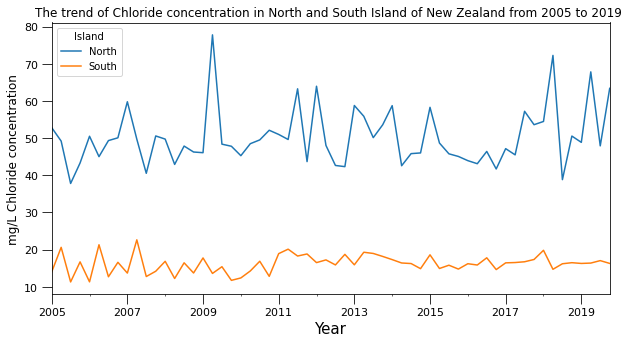

In [142]:
df.pivot_table(index = ['date'],columns = 'Island')['Chloride'].plot(figsize = (10,5))
plt.ylabel('mg/L Chloride concentration',size = 12 )
plt.xlabel('Year',size = 15 )
plt.title('The trend of Chloride concentration in North and South Island of New Zealand from 2005 to 2019 ',size = 12)
plt.tick_params(colors = 'black',size =10,labelsize = 11)

As we expected, the north island has greater fluctuate than the south island and it has more Chloride concentration than a south island in general over 15 years

### The effect of rainfall on chloride concentration
#### (Pooled  Regression and Fixed effects regression)

Before regression, we can draw a trend line of chloride concentration and rainfall in a different region to see whether there is some correlation between them.

In [143]:
pivot_Chloride = df.pivot_table(index = ['date'],columns = 'Region')['Chloride']
pivot_rainfall = df.pivot_table(index = ['date'],columns = 'Region')['rainfall']

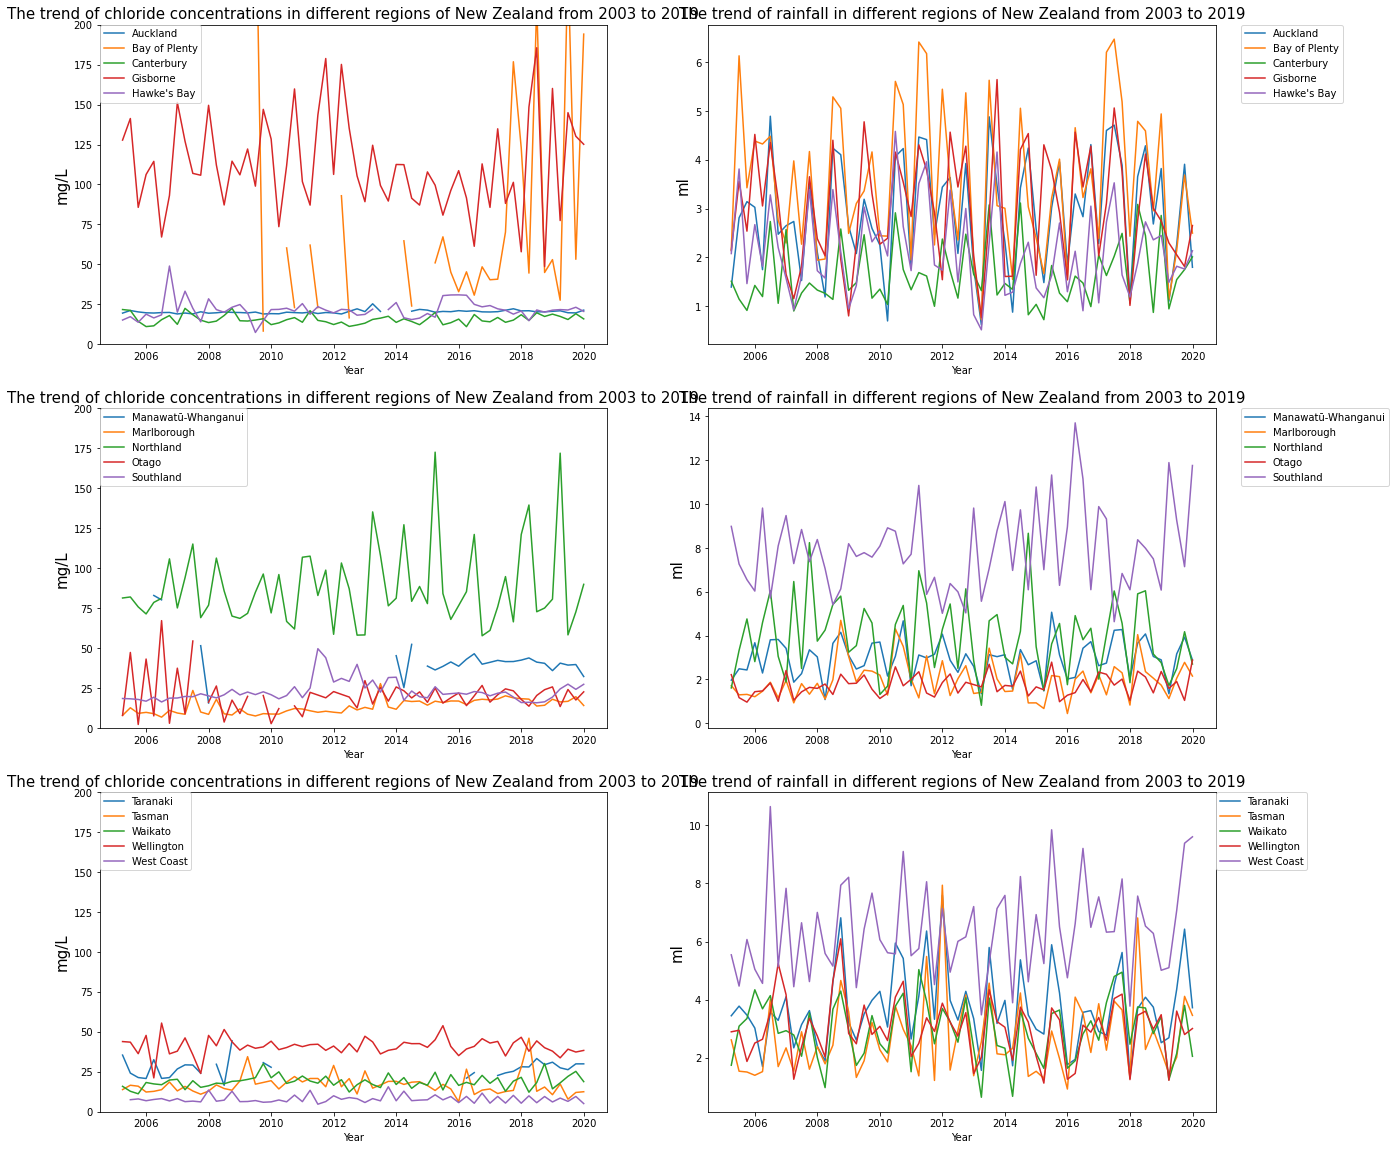

In [144]:
fig, axes = plt.subplots(3,2,figsize=(20,20))
###############################################################################################################################
## Auckland Bay of Plenty Canterbury Gisbone Hawke's  Bay 
# Chloride concentration
axes[0,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"])
axes[0,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[0,0].set_ylabel('mg/L',size = 15)
axes[0,0].set_xlabel('Year')
axes[0,0].legend(pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[0,0].set_ylim(0,200)

# Rainfall 
axes[0,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Auckland':"Hawke's Bay"])
axes[0,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[0,1].set_ylabel('ml',size = 15)
axes[0,1].set_xlabel('Year')
axes[0,1].legend(pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
###############################################################################################################################
## Manawatū-Whanganui Marlborough Northland Otago Southland
# Chloride concentration
axes[1,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"])
axes[1,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[1,0].set_ylabel('mg/L',size = 15)
axes[1,0].set_xlabel('Year')
axes[1,0].legend(pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[1,0].set_ylim(0,200)
# Rainfall 
axes[1,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Manawatū-Whanganu':"Southland"])
axes[1,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[1,1].set_ylabel('ml',size = 15)
axes[1,1].set_xlabel('Year')
axes[1,1].legend(pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
###############################################################################################################################
## Taranaki Tasman Waikato Wellington West Coast
# Chloride concentration
axes[2,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Taranaki':"West Coast"])
axes[2,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[2,0].set_ylabel('mg/L',size = 15)
axes[2,0].set_xlabel('Year')
axes[2,0].legend(pivot_Chloride.loc[:,'Taranaki':"West Coast"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[2,0].set_ylim(0,200)
# Rainfall 
axes[2,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Taranaki':"West Coast"])
axes[2,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[2,1].set_ylabel('ml',size = 15)
axes[2,1].set_xlabel('Year')
axes[2,1].legend(pivot_Chloride.loc[:,'Taranaki':"West Coast"].columns.values,bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)


As we can see from the above table, graphs on the first column show the chloride concentration and graphs on the second column show the rainfall of corresponding regions. 

There is a seasonal rainfall trend in most regions but only a few regions get an obvious seasonal trend of chloride concentration. And also there is no obvious evidence indicating that there is some correlation between chloride concentration and rainfall.

In [145]:
# Setting 2 indexes for panel data
data = df.pivot_table(index = ['Region','date'])
data

Chloride  Density (pop./km2)  Land area(km2)  \
Region     date                                                        
Auckland   2005-03-31  19.550000              347.60            4941   
           2005-06-30  21.175000              347.60            4941   
           2005-09-30  20.300000              347.60            4941   
           2005-12-31  19.743750              347.60            4941   
           2006-03-31  19.600000              347.60            4941   
...                          ...                 ...             ...   
West Coast 2018-12-31   6.144444                1.39           23245   
           2019-03-31   8.575758                1.39           23245   
           2019-06-30   6.525333                1.39           23245   
           2019-09-30   9.596875                1.39           23245   
           2019-12-31   5.145833                1.39           23245   

                       Population  rainfall  
Region     date                              
Auckland   2005-03-31     1717500  1.391111  
           2005-06-30     1717500  2.810440  
           2005-09-30     1717500  3.141304  
           2005-12-31     1717500  3.026087  
           2006-03-31     1717500  1.747778  
...                           ...       ...  
West Coast 2018-12-31       32400  5.013587  
           2019-03-31       32400  5.103333  
           2019-06-30       32400  7.069780  
           2019-09-30       32400  9.385870  
           2019-12-31       32400  9.606522  

[900 rows x 5 columns]

##### Pooled Regression

In [146]:
exog_vars = ['rainfall']
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data.Chloride, exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               Chloride   R-squared:                        0.0004
Estimator:                  PooledOLS   R-squared (Between):             -0.0012
No. Observations:                 816   R-squared (Within):               0.0019
Date:                Mon, May 31 2021   R-squared (Overall):              0.0004
Time:                        11:40:26   Log-likelihood                   -4072.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.3501
Entities:                          15   P-value                           0.5542
Avg Obs:                       54.400   Distribution:                   F(1,814)
Min Obs:                       31.000                                           
Max Obs:                       60.000   F-statistic (robust):             0.3501
                            

C:\Users\yy736\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


There are 15 entities in pooled data average time observations for those entities is 54.4 and the minimum and maximum time observations are 31 and 60 so it is an unbalanced dataset.

The P-value from pooled regression is 0.5542 which means that the association between rainfall and chloride concentrations is not statistically significant with a significance level of 0.05.

##### Fixed Effects Regression

In [147]:
exog_vars = ['rainfall']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.Chloride, exog, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:               Chloride   R-squared:                        0.0028
Estimator:                   PanelOLS   R-squared (Between):             -0.0026
No. Observations:                 816   R-squared (Within):               0.0028
Date:                Mon, May 31 2021   R-squared (Overall):             -0.0002
Time:                        11:40:26   Log-likelihood                   -3523.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.2241
Entities:                          15   P-value                           0.1363
Avg Obs:                       54.400   Distribution:                   F(1,800)
Min Obs:                       31.000                                           
Max Obs:                       60.000   F-statistic (robust):             2.2241
                            

Because the ANOVA test indicated that there are significant differences in Chloride concentrations among different regions. Therefore, fixed effects regression has been executed instead of random effects regression. The P-value of FE regression reduces to 0.1363 but is still over 0.05.

In conclusion, econometrically, rainfall has a negative relationship with chloride concentration. However, the association is not statistically significant.